## **Criando Métricas Personalizadas Para Keras/Tensorflow**

Você pode implementar sua própria métrica e usá-la como objetivo e na busca de hiperparâmetros.


Nesse notebook, iremos implementar com o Keras/Tensorflow duas métricas do Scikit-Learn para avaliar o desempenho de uma Rede Neural Convolucional (CNN):
* F1-Score
* Balanced Accuracy Score

Essas métricas são úteis para avaliar o desempenho de modelos de classificação, especialmente quando o conjunto de dados é desbalanceado.

[Custom metric as the objective](https://keras.io/guides/keras_tuner/getting_started/#tune-model-training)

#### **Métricas Personalizadas**

Se precisar de uma métrica que não faça parte da API Keras, você poderá criar facilmente métricas personalizadas criando uma subclasse da classe **keras.metrics.Metric**. Você precisará implementar 4 métodos:


1) Inicialização (__init__):
    * **__init__(self)**, em que você criará variáveis ​​de estado para sua métrica. 
    * Todas as variáveis ​​de estado devem ser criadas neste método chamando self.add_weight() como: self.var = self.add_weight(...)
2) Atualização do Estado (update_state):
    * **update_state(self, y_true, y_pred, sample_weight=None)**, que usa os alvos y_true e as previsões do modelo y_pred para atualizar as variáveis ​​de estado. 
    * Possui todas as atualizações nas variáveis ​​de estado como: self.var.assign_add(...).
3) Resultado (result):
    * **result(self)**, que usa as variáveis ​​de estado para calcular os resultados finais.
    * Calcula e retorna um valor escalar ou um ditado de valores escalares para a métrica das variáveis ​​de estado.
4) Reinicialização dos Estados (reset_states):
    * **reset_state(self)**, que reinicializa o estado da métrica.


A atualização do estado e o cálculo dos resultados são mantidos separados (em update_state() e result(), respectivamente) porque, em alguns casos, o cálculo dos resultados pode ser muito caro e só seria feito periodicamente.

[Custom Metrics](https://keras.io/guides/training_with_built_in_methods/)
[Base Metric Class](https://keras.io/api/metrics/base_metric/)

#### **Importando as Bibliotecas**

In [42]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print(tf.__version__)

2.16.1


#### **Classificação de Texto com Avaliações de Filmes**


Este notebook classifica avaliações de filmes como positiva ou negativa usando o texto da avaliação. Isto é um exemplo de classificação binária —ou duas-classes—, um importante e bastante aplicado tipo de problema de aprendizado de máquina.

Usaremos a base de dados IMDB que contém avaliaçòes de mais de 50000 filmes da base de dados Internet Movie Database. 

A base é dividida em 25000 avaliações para treinamento e 25000 para teste. Os conjuntos de **treinamentos e testes são balanceados**, ou seja, eles possuem a mesma quantidade de avaliações positivas e negativas.

O notebook utiliza tf.keras, uma API alto-nível para construir e treinar modelos com TensorFlow

[Text Classification Keras/Tensorflow](https://www.tensorflow.org/tutorials/keras/text_classification?hl=pt-br)

#### **Baixe a base de dados IMDB**

In [43]:
# A base de dados vem empacotada com TensorFlow. 
# Ela já vem pré-processada de forma que as avaliações (sequências de palavras) foram convertidas em sequências de inteiros, onde cada inteiro representa uma palavra específica no dicionário.
# O argumento num_words=10000 mantém as 10000 palavras mais frequentes no conjunto de treinamento. As palavras mais raras são descartadas para preservar o tamanho dos dados de forma maleável.

imdb = tf.keras.datasets.imdb

#### **Conjunto de Treinamento e Teste**

In [44]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


#### **Explore os dados**

In [45]:
# Vamos parar um momento para entender o formato dos dados. 
# O conjunto de dados vem pré-processado: cada exemplo é um array de inteiros representando as palavras da avaliação do filme. 
# Cada label é um inteiro com valor ou de 0 ou 1, onde 0 é uma avaliação negativa e 1 é uma avaliação positiva.
# O texto das avaliações foi convertido para inteiros, onde cada inteiro representa uma palavra específica no dicionário. Isso é como se parece a primeira revisão:

print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [46]:
# As avaliações dos filmes têm tamanhos diferentes. 
# O código abaixo mostra o número de palavras da primeira e segunda avaliação. 
# Sabendo que o número de entradas da rede neural tem que ser o mesmo também, temos que resolver isto mais tarde.

len(train_data[0]), len(train_data[1])

(218, 189)

In [47]:
train_data

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [48]:
train_labels

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

#### **Prepare os Dados**

As avaliações —os arrays de inteiros— devem ser convertidas em tensores (tensors) antes de alimentar a rede neural. Essa conversão pode ser feita de duas formas:

* Converter os arrays em vetores de 0s e 1s indicando a ocorrência da palavra, similar com one-hot encoding. Por exemplo, a sequência [3, 5] se tornaria um vetor de 10000 dimensões, onde todos seriam 0s, tirando 3 e 5, que são 1s. Depois, faça disso a primeira camada da nossa rede neural — a Dense layer — que pode trabalhar com dados em ponto flutuante. Essa abordagem é intensa em relação a memória, logo requer uma matriz de tamanho num_words * num_reviews.

* Alternativamente, podemos preencher o array para que todos tenho o mesmo comprimento, e depois criar um tensor inteiro de formato max_length * num_reviews. Podemos usar uma camada embedding capaz de lidar com o formato como a primeira camada da nossa rede.

Nesse notebook, usaremos a segunda abordagem.

In [49]:
# Já que as avaliações dos filmes devem ter o mesmo tamanho, usaremos a função pad_sequences para padronizar os tamanhos:

# Um dicionário mapeando palavras em índices inteiros
word_index = imdb.get_word_index()
word_index["<PAD>"] = 0

train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [50]:
train_data

array([[   1,   14,   22, ...,    0,    0,    0],
       [   1,  194, 1153, ...,    0,    0,    0],
       [   1,   14,   47, ...,    0,    0,    0],
       ...,
       [   1,   11,    6, ...,    0,    0,    0],
       [   1, 1446, 7079, ...,    0,    0,    0],
       [   1,   17,    6, ...,    0,    0,    0]])

In [51]:
# Agora, vamos olhar o tamanho dos exemplos:


len(train_data[0]), len(train_data[1])

(256, 256)

#### **Criando um Conjunto de Validação**

Quando treinamos. queremos checar a acurácia do modelo com os dados que ele nunca viu. 

Crie uma conjunto de validação tirando 10000 exemplos do conjunto de treinamento original. 

(Por que não usar o de teste agora? Nosso objetivo é desenvolver e melhorar (tunar) nosso modelo usando somente os dados de treinamento, depois usaremos o teste uma única vez para avaliar a previsão).

In [52]:
X_valid = train_data[:10000]
X_train = train_data[10000:]

y_valid = train_labels[:10000]
y_train = train_labels[10000:]


# Deixar no padrão 
X_test = test_data
y_test = test_labels

#### **Construindo o Modelo**

In [53]:
# O formato de entrada é a contagem vocabulário usados pelas avaliações dos filmes (10000 palavras)
vocab_size = 10000 # Número máximo de palavras a serem usadas
max_length = 16 # Tamanho máximo de cada sequência (padded/truncated)
embedding_dims = 128  # Dimensão dos vetores de embedding


def build_model(metric):
    # Configurando a arquitetura do modelo  
    model = tf.keras.Sequential()

    # --> Camada de Entrada
    # Geralmente, todas as camadas no Keras precisam conhecer a forma de suas entradas para poder criar seus pesos
    # Neste caso, você deve iniciar seu modelo passando um objeto Input para seu modelo, para que ele conheça sua forma de entrada desde o início
    # Modelos construídos com um formato de entrada predefinido como esse sempre possuem pesos (mesmo antes de ver qualquer dado) e sempre possuem um formato de saída definido.
    # Em geral, é uma prática recomendada sempre especificar antecipadamente o formato de entrada de um modelo Sequencial, se você souber o que é.
    # Uma alternativa simples é apenas passar um argumento input_shape para sua primeira camada:
    # Exemplo: model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dims, input_shape=(max_length,)))
    # No entanto, o exemplo acima gera um warning: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
    # https://keras.io/guides/sequential_model/
    # https://www.tensorflow.org/guide/keras/sequential_model?hl=pt-br
    model.add(tf.keras.Input(shape=(max_length,)))

    # Adicionando Camada de Incorporação - Transforma inteiros positivos (índices) em vetores densos de tamanho fixo.
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dims))

    # --> Camadas Intermediárias
    # Adicionando Camada de Convolução
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))

    # Adicionando Camada de Pooling
    model.add(tf.keras.layers.GlobalMaxPooling1D())
                                
    # Adicionando Camada Totalmente Conectada
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
 
    # --> Camada de Saída                 
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Sumário do modelo
    #model.summary()

    # Configurando o modelo para treinamento
    model.compile(optimizer=tf.keras.optimizers.Adam(name='adam', learning_rate=0.001),   # O learning_rate padrão é 0.001 
                    # Já que é um problema de classificação binário e o modelo tem como saída uma probabilidade usaremos a função loss "binary_crossentropy". A binary_crossentropy é a melhor função de loss para tratar probabilidades— ela mede a "distância" entre as distribuições de probabilidade, ou, no nosso caso, sobre a distribuição real e as previsões.
                    loss=tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'), 
                    # Usaremos como métrica a binary_accuracy. Essa métrica é utilizada especificamente em problemas de classificação binária e calcula com que frequência as previsões correspondem aos rótulos binários.
                    metrics=[metric])
    
    # Treinando o modelo
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=10,
                        batch_size=512,
                        verbose=1,
                        validation_data=(X_valid, y_valid))

    return model, history

In [54]:
# Usando a métrica BinaryAccuracy
metric = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')

model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - binary_accuracy: 0.5605 - loss: 0.6847 - val_binary_accuracy: 0.7088 - val_loss: 0.5899
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - binary_accuracy: 0.7614 - loss: 0.5238 - val_binary_accuracy: 0.8334 - val_loss: 0.3809
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - binary_accuracy: 0.8757 - loss: 0.3034 - val_binary_accuracy: 0.8723 - val_loss: 0.2965
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 991ms/step - binary_accuracy: 0.9440 - loss: 0.1706 - val_binary_accuracy: 0.8834 - val_loss: 0.2812
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - binary_accuracy: 0.9810 - loss: 0.0845 - val_binary_accuracy: 0.8832 - val_loss: 0.2988
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 995ms/step - binary_accuracy: 0.9957 - loss: 0.0368 - val_binary_accuracy: 0.8830 - val_loss: 0.3190
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 983ms/step - binary_accuracy: 0.9993 - loss: 0.0146 - val_binary_accuracy: 0.8855 - val_loss: 0.3430
Epoch 8/

In [55]:
# O y_valid é um array de 1 Dimensão com valores inteiros.
y_valid

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [56]:
# O y_pred é um array de 2 Dimensões com valores flutuantes, ou seja, com probabilidades das classes. 
# Precisamos transformar os valores flutuantes em inteiros e converter o array para 1D
y_pred = model.predict(X_valid)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


array([[9.9768692e-01],
       [8.6091304e-06],
       [1.0936255e-05],
       ...,
       [9.9984354e-01],
       [3.5684966e-04],
       [3.1184158e-04]], dtype=float32)

In [57]:
# Iremos usar as funçãoes do Tensorflow, mas também é possível usar o numpy
# 1) Arrendondar os valores do array
# 2) Transformar o array de 2D para 1D
# 3) Converter o tipo do array para int32
y_pred = tf.cast(tf.reshape(tf.round(y_pred), -1), dtype='int32')
y_pred

<tf.Tensor: shape=(10000,), dtype=int32, numpy=array([1, 0, 0, ..., 1, 0, 0])>

In [58]:
# O y_pred é um tensor do tipo int32.
# Vamos converter o y_valid para tensor do tipo int32
y_valid_tensor =  tf.cast(tf.convert_to_tensor(y_valid), dtype='int32')
y_valid_tensor

<tf.Tensor: shape=(10000,), dtype=int32, numpy=array([1, 0, 0, ..., 1, 0, 0])>

In [59]:
# Transforma o array/tensor em valores booleanos [0, 1, 0, 1] -> [False, True, False, True]
y_valid_bool = tf.keras.ops.cast(y_valid_tensor, "bool")
y_pred_bool  = tf.keras.ops.cast(y_pred, "bool")

y_valid_bool

<tf.Tensor: shape=(10000,), dtype=bool, numpy=array([ True, False, False, ...,  True, False, False])>

In [60]:
# Usaremos a função lógica "and" para verifica a quantidade de valores verdadeiros e falsos
#  A    and    B       S
# True       True  = True
# False      False = False
# True       True  = False
# True       True  = False
values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_valid_bool, True), tf.keras.ops.equal(y_pred_bool, True))

# Converte o array/tensor de booleanos para inteiros
values = tf.keras.ops.cast(values, dtype='int32')
values

<tf.Tensor: shape=(10000,), dtype=int32, numpy=array([1, 0, 0, ..., 1, 0, 0])>

In [61]:
# Calcula a soma dos elementos nas dimensões de um tensor.
tp = tf.reduce_sum(values).numpy()
tp

4506

#### **Criando a Métrica F1-Score Customizada (sem parâmetro) usando Keras/Tensorflow**

O F1-Score é a média harmônica entre precisão (precision) e revocação (recall), sendo uma métrica útil para avaliar a performance de modelos de classificação, especialmente quando há uma classe desbalanceada.

[f1-score-guide](https://www.v7labs.com/blog/f1-score-guide)

In [62]:
# O Tensorflow 2 possui uma opção de configuração para executar funções "avidamente", o que permitirá obter valores do Tensor por meio do método .numpy(). 
# Para habilitar a execução antecipada, use o seguinte comando: tf.config.run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [63]:
class F1ScoreA(tf.keras.metrics.Metric): 
    def __init__(self, name='f1_score', **kwargs):
        super(F1ScoreA, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        # O y_true é um array de 1 Dimensão com valores inteiros.
        # O y_pred é um array de 2 Dimensões com valores flutuantes, ou seja, com probabilidades das classes. 
        # Precisamos transformar o y_pred em inteiros e converter o array para 1D
        # Iremos usar as funçãoes do Tensorflow
        # 1) Arrendondar os valores do array
        # 2) Transformar o array de 2D para 1D
        # 3) Converter o tipo do array para int32
        y_pred = tf.cast(tf.reshape(tf.round(y_pred), -1), dtype='int32')

        # O y_pred é um tensor do tipo int32.
        # Vamos converter o y_true para tensor do tipo int32
        y_true = tf.cast(tf.convert_to_tensor(y_true), dtype='int32')

        # Transforma o array em valores booleanos [0, 1, 0, 1] -> [False, True, False, True]
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(y_pred, "bool")

        # Verifica a quantidade de VERDADEIROS POSITIVOS (TP)
        # Usaremos a função lógica "and" para verifica a quantidade de valores verdadeiros e falsos
        #  A    and    B       S
        # True       True  = True
        # False      False = False
        # True       True  = False
        # True       True  = False
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        tp = tf.reduce_sum(values)
        
        # Verifica a quantidade de VERDADEIROS NEGATIVOS (TN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        tn = tf.reduce_sum(values)
        
        # Verifica a quantidade de FALSO POSITIVO (FP)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        fp = tf.reduce_sum(values)

        # Verifica a quantidade de FALSO NEGATIVO (FN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        fn = tf.reduce_sum(values) 

        # assign_add e assign em TensorFlow são usadas para atualizar os valores de tensores que foram definidos como variáveis de estado dentro de uma classe
        # assign_add
        # Função: Incrementa o valor da variável pelo valor especificado.
        # Uso: É útil quando você deseja somar um valor ao valor atual da variável.
        # Exemplo: self.true_positives.assign_add(tn)
        # Isso adiciona o número de verdadeiros positivos encontrados na batch atual ao total acumulado de verdadeiros positivos.
        # Use assign_add quando você precisa acumular valores ao longo do tempo, como ao acumular contagens de verdadeiros positivos, falsos positivos, etc., durante várias iterações ou batches de treinamento.
        
        self.true_positives.assign_add(tp)
        self.true_negatives.assign_add(tn)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
        
    def result(self):

        f1_1 = (2 * self.true_positives) / (2 * self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_0 = (2 * self.true_negatives) / (2 * self.true_negatives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())

        # F1-Score Macro
        f = (f1_1 + f1_0) / 2 
    
        return f

    def reset_states(self):
        self.true_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

#### **Notas Adicionais**

* **Compatibilidade**: A implementação da métrica deve garantir que todas as operações sejam compatíveis com as operações do TensorFlow.
* **Estado**: Usar self.add_weight permite que a métrica mantenha estados persistentes durante o treinamento.
* **Customização**: A abordagem usando a classe Metric facilita o reuso e a manutenção da métrica personalizada, especialmente em projetos complexos.
* **Precisão Numérica**: A adição de tf.keras.backend.epsilon() evita divisões por zero.

Essa implementação permite que você utilize a métrica F1-Score durante o treinamento e a avaliação do seu modelo de forma eficiente e integrada.

In [64]:
# Passando a métrica para o modelo
model, history = build_model(F1ScoreA())

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - f1_score: 0.5265 - loss: 0.6863 - val_f1_score: 0.7621 - val_loss: 0.6020
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.7729 - loss: 0.5333 - val_f1_score: 0.8205 - val_loss: 0.4007
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.8603 - loss: 0.3320 - val_f1_score: 0.8675 - val_loss: 0.3093
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 993ms/step - f1_score: 0.9333 - loss: 0.1938 - val_f1_score: 0.8814 - val_loss: 0.2813
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.9729 - loss: 0.1058 - val_f1_score: 0.8841 - val_loss: 0.2879
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 998ms/step - f1_score: 0.9930 - loss: 0.0441 - val_f1_score: 0.8838 - val_loss: 0.3111
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.9983 - loss: 0.0205 - val_f1_score: 0.8816 - val_loss: 0.3362
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 994ms/step - f1_score: 1.0000 - loss: 0.0084 - val_f1_score: 0.8810 - 

In [65]:
metric = F1ScoreA()
metric.update_state(y_valid, model.predict(X_valid))
f1_macro_valid_a = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

print(f'F1-Score Macro Valid {f1_macro_valid_a}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
F1-Score Macro Valid 0.88


**Visualização das Métricas da CNN Durante o Treinamento**

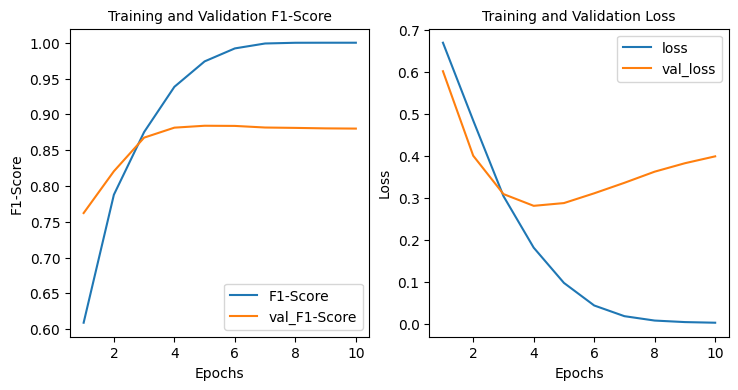

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(8.5,4))

acc = history.history['f1_score']
val_acc = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

sns.lineplot(x=epochs, y=loss, ax=ax[1], label='loss')
sns.lineplot(x=epochs, y=val_loss, ax=ax[1], label='val_loss')
ax[1].set_title("Training and Validation Loss", size=10)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')


sns.lineplot(x=epochs, y=acc, ax=ax[0], label='F1-Score')
sns.lineplot(x=epochs, y=val_acc, ax=ax[0], label='val_F1-Score')
ax[0].set_title("Training and Validation F1-Score", size=10)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('F1-Score')


plt.show()

In [67]:
print(classification_report(y_valid, np.reshape(np.round(model.predict(X_valid)), -1)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4947
           1       0.88      0.88      0.88      5053

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



#### **Criando a Métrica F1-Score Customizada (com parâmetro) usando Keras/Tensorflow**

In [68]:
# Aplicar limite de decisão para as probabilidades do modelo
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

class F1ScoreC(tf.keras.metrics.Metric):     
    def __init__(self, Tipo='macro', Threshold=0.5, name='f1', **kwargs):
        super(F1ScoreC, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
        self.Tipo = Tipo
        self.Threshold = Threshold

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        # O y_true é um array de 1 Dimensão com valores inteiros.
        # O y_pred é um array de 2 Dimensões com valores flutuantes, ou seja, com probabilidades das classes. 
        # Precisamos transformar o y_pred em inteiros e converter o array para 1D
        # Iremos usar as funçãoes do Tensorflow
        # 1) Arrendondar os valores do array
        # 2) Transformar o array de 2D para 1D
        # 3) Converter o tipo do array para int32
        if self.Threshold != 0.5:
            y_pred = to_labels(tf.reshape(y_pred, -1).numpy(), self.Threshold)
            y_pred= tf.cast(tf.convert_to_tensor(y_pred), dtype='int32')
        else:
            y_pred = tf.cast(tf.reshape(tf.round(y_pred), -1), dtype='int32')

        # O y_pred é um tensor do tipo int32.
        # Vamos converter o y_true para tensor do tipo int32
        y_true = tf.cast(tf.convert_to_tensor(y_true), dtype='int32')

        # Transforma o array em valores booleanos [0, 1, 0, 1] -> [False, True, False, True]
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(y_pred, "bool")

        # Verifica a quantidade de VERDADEIROS POSITIVOS (TP)
        # Usaremos a função lógica "and" para verifica a quantidade de valores verdadeiros e falsos
        #  A    and    B       S
        # True       True  = True
        # False      False = False
        # True       True  = False
        # True       True  = False
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        tp = tf.reduce_sum(values)
        
        # Verifica a quantidade de VERDADEIROS NEGATIVOS (TN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        tn = tf.reduce_sum(values)
        
        # Verifica a quantidade de FALSO POSITIVO (FP)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        fp = tf.reduce_sum(values)

        # Verifica a quantidade de FALSO NEGATIVO (FN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        fn = tf.reduce_sum(values) 

        # assign_add e assign em TensorFlow são usadas para atualizar os valores de tensores que foram definidos como variáveis de estado dentro de uma classe
        # assign_add
        # Função: Incrementa o valor da variável pelo valor especificado.
        # Uso: É útil quando você deseja somar um valor ao valor atual da variável.
        # Exemplo: self.true_positives.assign_add(tn)
        # Isso adiciona o número de verdadeiros positivos encontrados na batch atual ao total acumulado de verdadeiros positivos.
        # Use assign_add quando você precisa acumular valores ao longo do tempo, como ao acumular contagens de verdadeiros positivos, falsos positivos, etc., durante várias iterações ou batches de treinamento.
        
        self.true_positives.assign_add(tp)
        self.true_negatives.assign_add(tn)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
        
    def result(self):
        f = 0

        f1_1 = (2 * self.true_positives) / (2 * self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_0 = (2 * self.true_negatives) / (2 * self.true_negatives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())

        if self.Tipo == 'macro':
            f = (f1_1 + f1_0) / 2
        elif self.Tipo == 'micro':
            f = (self.true_positives + self.true_negatives) / (self.true_positives + self.false_positives + self.false_negatives + self.true_negatives + tf.keras.backend.epsilon())
        elif self.Tipo == 'weighted':
            f = (((self.true_positives + self.false_negatives) * f1_1) + ((self.false_positives + self.true_negatives) * f1_0)) / ((self.true_positives + self.false_negatives) + (self.false_positives + self.true_negatives) + tf.keras.backend.epsilon())
    
        return f

    def reset_states(self):
        self.true_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

**Passando o Tipo**

In [69]:
# F1-Score
metric = F1ScoreC('weighted')

# Passando a métrica para o modelo
model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.5236 - loss: 0.6843 - val_f1: 0.7185 - val_loss: 0.5864
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 975ms/step - f1: 0.7600 - loss: 0.5203 - val_f1: 0.8287 - val_loss: 0.3847
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.8837 - loss: 0.3047 - val_f1: 0.8733 - val_loss: 0.3005
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - f1: 0.9505 - loss: 0.1657 - val_f1: 0.8795 - val_loss: 0.2940
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - f1: 0.9813 - loss: 0.0856 - val_f1: 0.8810 - val_loss: 0.2960
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - f1: 0.9971 - loss: 0.0366 - val_f1: 0.8850 - val_loss: 0.3108
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - f1: 0.9997 - loss: 0.0153 - val_f1: 0.8846 - val_loss: 0.3346
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.9999 - loss: 0.0071 - val_f1: 0.8834 - val_loss: 0.3535
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - f1: 1.0000 - loss: 0.0044 - val_f

In [70]:
y_pred = model.predict(X_valid)

metric = F1ScoreC('weighted')
metric.update_state(y_valid, y_pred)
f1_weighted_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreC('macro')
metric.update_state(y_valid, y_pred)
f1_macro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreC('micro')
metric.update_state(y_valid, y_pred)
f1_micro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)


print(f'F1-Score Macro Valid {f1_macro_valid_c} F1-Score Micro Valid {f1_micro_valid_c} F1-Score Weighted Valid {f1_weighted_valid_c}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step
F1-Score Macro Valid 0.88 F1-Score Micro Valid 0.88 F1-Score Weighted Valid 0.88


In [71]:
print(classification_report(y_valid, np.reshape(np.round(y_pred), -1)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4947
           1       0.88      0.89      0.88      5053

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



**Passando o Tipo e o Threshold**

In [72]:
# F1-Score
metric = F1ScoreC('weighted', 0.356)

# Passando a métrica para o modelo
model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - f1: 0.3316 - loss: 0.6834 - val_f1: 0.5842 - val_loss: 0.5845
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - f1: 0.6714 - loss: 0.5082 - val_f1: 0.7904 - val_loss: 0.3742
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.8573 - loss: 0.2902 - val_f1: 0.8654 - val_loss: 0.2964
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - f1: 0.9412 - loss: 0.1600 - val_f1: 0.8793 - val_loss: 0.2810
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.9766 - loss: 0.0853 - val_f1: 0.8792 - val_loss: 0.2928
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 994ms/step - f1: 0.9940 - loss: 0.0365 - val_f1: 0.8817 - val_loss: 0.3162
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 998ms/step - f1: 0.9998 - loss: 0.0147 - val_f1: 0.8825 - val_loss: 0.3411
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 991ms/step - f1: 0.9998 - loss: 0.0077 - val_f1: 0.8823 - val_loss: 0.3634
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.9999 - loss: 0.0043 -

In [73]:
y_pred = model.predict(X_valid)

metric = F1ScoreC('weighted', 0.356)
metric.update_state(y_valid, y_pred)
f1_weighted_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreC('macro', 0.356)
metric.update_state(y_valid, y_pred)
f1_macro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreC('micro', 0.356)
metric.update_state(y_valid, y_pred)
f1_micro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)


print(f'F1-Score Macro Valid {f1_macro_valid_c} F1-Score Micro Valid {f1_micro_valid_c} F1-Score Weighted Valid {f1_weighted_valid_c}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step
F1-Score Macro Valid 0.88 F1-Score Micro Valid 0.88 F1-Score Weighted Valid 0.88


In [74]:
y_pred_ = tf.cast(tf.convert_to_tensor(to_labels(tf.reshape(y_pred, -1).numpy(), 0.356)), dtype='int32')

In [75]:
print(classification_report(y_valid, y_pred_))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4947
           1       0.87      0.91      0.89      5053

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



#### **Criando a Métrica F1-Score Customizada (com parâmetro) usando Keras/Tensorflow e Numpy**

In [76]:
# Aplicar limite de decisão para as probabilidades do modelo
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

class F1ScoreD(tf.keras.metrics.Metric):     
    def __init__(self, Tipo='macro', Threshold=0.5, name='f1', **kwargs):
        super(F1ScoreD, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
        self.Tipo = Tipo
        self.Threshold = Threshold

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        # O y_true é um array de 1 Dimensão com valores inteiros.
        # O y_pred é um array de 2 Dimensões com valores flutuantes, ou seja, com probabilidades das classes. 
        # Precisamos transformar o y_pred em inteiros e converter o array para 1D
        # Iremos usar as funçãoes do Tensorflow
        # 1) Arrendondar os valores do array
        # 2) Transformar o array de 2D para 1D
        # 3) Converter o tipo do array para int32
        if self.Threshold != 0.5:
            y_pred = to_labels(tf.reshape(y_pred, -1).numpy(), self.Threshold)
        else:
            y_pred = np.array(np.reshape(np.round(y_pred), -1), np.int32)


        # Transforma o array em valores booleanos [0, 1, 0, 1] -> [False, True, False, True]
        y_true = np.bool_(y_true)
        y_pred = np.bool_(y_pred)

        # Verifica a quantidade de VERDADEIROS POSITIVOS (TP)
        # Usaremos a função lógica "and" para verifica a quantidade de valores verdadeiros e falsos
        #  A    and    B       S
        # True       True  = True
        # False      False = False
        # True       True  = False
        # True       True  = False
        values = np.logical_and(np.equal(y_true, True), np.equal(y_pred, True))
        # Transforma o array/list de booleano para inteiro: [False,  True, False,  True] --> [0,1,0,1]
        values = values.astype(int)  
        # Faz a soma do array/list
        tp = np.sum(values)
        
        # Verifica a quantidade de VERDADEIROS NEGATIVOS (TN)
        values = np.logical_and(np.equal(y_true, False), np.equal(y_pred, False))
        # Transforma o array/list de booleano para inteiro: [False,  True, False,  True] --> [0,1,0,1]
        values = values.astype(int)  
        # Faz a soma do array/list
        tn = np.sum(values)
        
        # Verifica a quantidade de FALSO POSITIVO (FP)
        values = np.logical_and(np.equal(y_true, False), np.equal(y_pred, True))
        # Transforma o array/list de booleano para inteiro: [False,  True, False,  True] --> [0,1,0,1]
        values = values.astype(int)  
        # Faz a soma do array/list
        fp = np.sum(values)

        # Verifica a quantidade de FALSO NEGATIVO (FN)
        values = np.logical_and(np.equal(y_true, True), np.equal(y_pred, False))
        # Transforma o array/list de booleano para inteiro: [False,  True, False,  True] --> [0,1,0,1]
        values = values.astype(int)  
        # Faz a soma do array/list
        fn = np.sum(values)

        # assign_add e assign em TensorFlow são usadas para atualizar os valores de tensores que foram definidos como variáveis de estado dentro de uma classe
        # assign_add
        # Função: Incrementa o valor da variável pelo valor especificado.
        # Uso: É útil quando você deseja somar um valor ao valor atual da variável.
        # Exemplo: self.true_positives.assign_add(tn)
        # Isso adiciona o número de verdadeiros positivos encontrados na batch atual ao total acumulado de verdadeiros positivos.
        # Use assign_add quando você precisa acumular valores ao longo do tempo, como ao acumular contagens de verdadeiros positivos, falsos positivos, etc., durante várias iterações ou batches de treinamento.
        
        self.true_positives.assign_add(tp)
        self.true_negatives.assign_add(tn)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
        
    def result(self):
        f = 0

        f1_1 = (2 * self.true_positives) / (2 * self.true_positives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_0 = (2 * self.true_negatives) / (2 * self.true_negatives + self.false_positives + self.false_negatives + tf.keras.backend.epsilon())

        if self.Tipo == 'macro':
            f = (f1_1 + f1_0) / 2 
        elif self.Tipo == 'micro':
            f = (self.true_positives + self.true_negatives) / (self.true_positives + self.false_positives + self.false_negatives + self.true_negatives + tf.keras.backend.epsilon())
        elif self.Tipo == 'weighted':
            f = (((self.true_positives + self.false_negatives) * f1_1) + ((self.false_positives + self.true_negatives) * f1_0)) / ((self.true_positives + self.false_negatives) + (self.false_positives + self.true_negatives) + tf.keras.backend.epsilon())
    
        return f

    def reset_states(self):
        self.true_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

In [77]:
# F1-Score
metric = F1ScoreD('weighted', 0.356)

# Passando a métrica para o modelo
model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 982ms/step - f1: 0.3377 - loss: 0.6860 - val_f1: 0.6032 - val_loss: 0.6068
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - f1: 0.6481 - loss: 0.5464 - val_f1: 0.7711 - val_loss: 0.4132
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1: 0.8343 - loss: 0.3392 - val_f1: 0.8600 - val_loss: 0.3087
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 975ms/step - f1: 0.9212 - loss: 0.1987 - val_f1: 0.8785 - val_loss: 0.2824
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 973ms/step - f1: 0.9645 - loss: 0.1065 - val_f1: 0.8854 - val_loss: 0.2928
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - f1: 0.9908 - loss: 0.0516 - val_f1: 0.8844 - val_loss: 0.3099
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 968ms/step - f1: 0.9975 - loss: 0.0232 - val_f1: 0.8833 - val_loss: 0.3298
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 989ms/step - f1: 0.9998 - loss: 0.0100 - val_f1: 0.8839 - val_loss: 0.3498
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 968ms/step - f1: 0.9999 -

In [78]:
y_pred = model.predict(X_valid)

metric = F1ScoreD('weighted', 0.356)
metric.update_state(y_valid, y_pred)
f1_weighted_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreD('macro', 0.356)
metric.update_state(y_valid, y_pred)
f1_macro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreD('micro', 0.356)
metric.update_state(y_valid, y_pred)
f1_micro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)


print(f'F1-Score Macro Valid {f1_macro_valid_c} F1-Score Micro Valid {f1_micro_valid_c} F1-Score Weighted Valid {f1_weighted_valid_c}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step
F1-Score Macro Valid 0.88 F1-Score Micro Valid 0.88 F1-Score Weighted Valid 0.88


#### **Métrica F1-Score Customizada (com parâmetros) usando Keras/TensorFlow e Scikit-Learn**

In [79]:
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


class F1ScoreE(tf.keras.metrics.Metric):
    def __init__(self, Tipo='macro', Threshold=0.5, name='f1', **kwargs):
        super(F1ScoreE, self).__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1_', initializer='zeros')
        self.Tipo = Tipo
        self.Threshold = Threshold

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.Threshold != 0.5:
            y_pred = to_labels(tf.reshape(y_pred, -1).numpy(), self.Threshold)
        else:
            y_pred = np.array(np.reshape(np.round(y_pred), -1), np.int32)

        f1 = f1_score(y_true, y_pred, average=self.Tipo)

        self.f1.assign(f1)     

    def result(self):
        return self.f1

    def reset_states(self):
        self.f1.assign(0)

In [80]:
# F1-Score
metric = F1ScoreE('weighted', 0.356)

# Passando a métrica para o modelo
model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 970ms/step - f1: 0.3397 - loss: 0.6866 - val_f1: 0.5097 - val_loss: 0.6123
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 981ms/step - f1: 0.6966 - loss: 0.5440 - val_f1: 0.8063 - val_loss: 0.4077
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 965ms/step - f1: 0.8557 - loss: 0.3268 - val_f1: 0.8707 - val_loss: 0.3140
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 968ms/step - f1: 0.9230 - loss: 0.1973 - val_f1: 0.8708 - val_loss: 0.2883
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 971ms/step - f1: 0.9623 - loss: 0.1094 - val_f1: 0.8819 - val_loss: 0.2972
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 970ms/step - f1: 0.9861 - loss: 0.0523 - val_f1: 0.8897 - val_loss: 0.3135
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 968ms/step - f1: 0.9942 - loss: 0.0226 - val_f1: 0.8859 - val_loss: 0.3352
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 973ms/step - f1: 0.9961 - loss: 0.0122 - val_f1: 0.8858 - val_loss: 0.3627
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 984ms/step - f1: 0.996

In [81]:
y_pred = model.predict(X_valid)

metric = F1ScoreE('weighted', 0.356)
metric.update_state(y_valid, y_pred)
f1_weighted_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreE('macro', 0.356)
metric.update_state(y_valid, y_pred)
f1_macro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

metric = F1ScoreE('micro', 0.356)
metric.update_state(y_valid, y_pred)
f1_micro_valid_c = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)


print(f'F1-Score Macro Valid {f1_macro_valid_c} F1-Score Micro Valid {f1_micro_valid_c} F1-Score Weighted Valid {f1_weighted_valid_c}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step
F1-Score Macro Valid 0.88 F1-Score Micro Valid 0.88 F1-Score Weighted Valid 0.88


In [82]:
y_pred_ = tf.cast(tf.convert_to_tensor(to_labels(tf.reshape(y_pred, -1).numpy(), 0.356)), dtype='int32')
print(classification_report(y_valid, y_pred_))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4947
           1       0.86      0.90      0.88      5053

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



#### **Métrica Balanced Accuracy Customizada com Keras/Tensorflow**

A balanced_accuracy_score função calcula a precisão balanceada, o que evita estimativas de desempenho inflacionadas em conjuntos de dados desequilibrados. 

No caso binário, a precisão balanceada é igual à média aritmética de sensibilidade (taxa verdadeira positiva) e especificidade (taxa verdadeira negativa), ou a área sob a curva ROC com previsões binárias em vez de pontuações.

In [83]:
# Aplicar limite de decisão para as probabilidades do modelo
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

class CustomBalancedAccuracyA(tf.keras.metrics.Metric):
    def __init__(self, Threshold=0.5, name='CustomBalancedAccuracy', **kwargs):
        super(CustomBalancedAccuracyA, self).__init__(name=name, **kwargs)
        self.Threshold = Threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # O y_true é um array de 1 Dimensão com valores inteiros.
        # O y_pred é um array de 2 Dimensões com valores flutuantes, ou seja, com probabilidades das classes. 
        # Precisamos transformar o y_pred em inteiros e converter o array para 1D
        # Iremos usar as funçãoes do Tensorflow
        # 1) Arrendondar os valores do array
        # 2) Transformar o array de 2D para 1D
        # 3) Converter o tipo do array para int32
        if self.Threshold != 0.5:
            y_pred = to_labels(tf.reshape(y_pred, -1).numpy(), self.Threshold)
            y_pred= tf.cast(tf.convert_to_tensor(y_pred), dtype='int32')
        else:
            y_pred = tf.cast(tf.reshape(tf.round(y_pred), -1), dtype='int32')

        # O y_pred é um tensor do tipo int32.
        # Vamos converter o y_true para tensor do tipo int32
        y_true = tf.cast(tf.convert_to_tensor(y_true), dtype='int32')

        # Transforma o array em valores booleanos [0, 1, 0, 1] -> [False, True, False, True]
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(y_pred, "bool")

        # Verifica a quantidade de VERDADEIROS POSITIVOS (TP)
        # Usaremos a função lógica "and" para verifica a quantidade de valores verdadeiros e falsos
        #  A    and    B       S
        # True       True  = True
        # False      False = False
        # True       True  = False
        # True       True  = False
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        tp = tf.reduce_sum(values)
        
        # Verifica a quantidade de VERDADEIROS NEGATIVOS (TN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        tn = tf.reduce_sum(values)
        
        # Verifica a quantidade de FALSO POSITIVO (FP)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        values = tf.keras.ops.cast(values, dtype='int32')
        fp = tf.reduce_sum(values)

        # Verifica a quantidade de FALSO NEGATIVO (FN)
        values = tf.keras.ops.logical_and(tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        values = tf.keras.ops.cast(values, dtype='int32')
        fn = tf.reduce_sum(values) 

        # assign_add e assign em TensorFlow são usadas para atualizar os valores de tensores que foram definidos como variáveis de estado dentro de uma classe
        # assign_add
        # Função: Incrementa o valor da variável pelo valor especificado.
        # Uso: É útil quando você deseja somar um valor ao valor atual da variável.
        # Exemplo: self.true_positives.assign_add(tn)
        # Isso adiciona o número de verdadeiros positivos encontrados na batch atual ao total acumulado de verdadeiros positivos.
        # Use assign_add quando você precisa acumular valores ao longo do tempo, como ao acumular contagens de verdadeiros positivos, falsos positivos, etc., durante várias iterações ou batches de treinamento.
      
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.true_negatives.assign_add(tn)
        self.false_negatives.assign_add(fn)
    
    def result(self):
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        specificity = self.true_negatives / (self.true_negatives + self.false_positives + tf.keras.backend.epsilon())
        balanced_accuracy = (recall + specificity) / 2
        return balanced_accuracy
    
    def reset_states(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_negatives.assign(0.0)

In [84]:
# BalancedAccuracyA
metric =  CustomBalancedAccuracyA(0.356)

# Passando a métrica para o modelo
model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 991ms/step - CustomBalancedAccuracy: 0.5014 - loss: 0.6843 - val_CustomBalancedAccuracy: 0.6425 - val_loss: 0.5881
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - CustomBalancedAccuracy: 0.6888 - loss: 0.5190 - val_CustomBalancedAccuracy: 0.7836 - val_loss: 0.3904
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - CustomBalancedAccuracy: 0.8527 - loss: 0.3080 - val_CustomBalancedAccuracy: 0.8721 - val_loss: 0.3011
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - CustomBalancedAccuracy: 0.9393 - loss: 0.1670 - val_CustomBalancedAccuracy: 0.8781 - val_loss: 0.2798
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - CustomBalancedAccuracy: 0.9774 - loss: 0.0809 - val_CustomBalancedAccuracy: 0.8679 - val_loss: 0.3018
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 994ms/step - CustomBalancedAccuracy: 0.9947 - loss: 0.0356 - val_CustomBalancedAccuracy: 0.8807 - val_loss: 0.3114
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - CustomBalancedAccu

In [85]:
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_valid)

metric = CustomBalancedAccuracyA(0.356)
metric.update_state(y_valid, y_pred)
ba_valid_a = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

score = np.round(balanced_accuracy_score(y_valid, to_labels(np.reshape(y_pred, -1), 0.356)), 2)

print(f'CustomBalancedAccuracyA Valid {ba_valid_a} {score}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
CustomBalancedAccuracyA Valid 0.88 0.88


#### **Métrica Balanced Accuracy Customizada com Keras/Tensorflow e Scikit-Learn**

In [86]:
from sklearn.metrics import balanced_accuracy_score

# Aplicar limite de decisão para as probabilidades do modelo
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


class CustomBalancedAccuracyB(tf.keras.metrics.Metric):
    def __init__(self, Threshold=0.5, name='CustomBalancedAccuracy', **kwargs):
        super(CustomBalancedAccuracyB, self).__init__(name=name, **kwargs)
        self.balanced_acc = self.add_weight(name='Acc', initializer='zeros')
        self.Threshold = Threshold

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.Threshold != 0.5:
            y_pred = to_labels(tf.reshape(y_pred, -1).numpy(), self.Threshold)
        else:
            y_pred = np.array(np.reshape(np.round(y_pred), -1), np.int32)

        bc = balanced_accuracy_score(y_true, y_pred) 

        self.balanced_acc.assign(bc)     

    def result(self):
        return self.balanced_acc

    def reset_states(self):
        self.balanced_acc.assign(0)

In [87]:
# BalancedAccuracy
metric = CustomBalancedAccuracyB(0.356)

# Passando a métrica para o modelo
model, history = build_model(metric)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - CustomBalancedAccuracy: 0.5207 - loss: 0.6845 - val_CustomBalancedAccuracy: 0.6541 - val_loss: 0.5989
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 976ms/step - CustomBalancedAccuracy: 0.7363 - loss: 0.5261 - val_CustomBalancedAccuracy: 0.7964 - val_loss: 0.3938
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 983ms/step - CustomBalancedAccuracy: 0.8624 - loss: 0.3243 - val_CustomBalancedAccuracy: 0.8576 - val_loss: 0.3083
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 975ms/step - CustomBalancedAccuracy: 0.9284 - loss: 0.1836 - val_CustomBalancedAccuracy: 0.8798 - val_loss: 0.2905
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - CustomBalancedAccuracy: 0.9675 - loss: 0.1019 - val_CustomBalancedAccuracy: 0.8759 - val_loss: 0.2986
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 961ms/step - CustomBalancedAccuracy: 0.9888 - loss: 0.0432 - val_CustomBalancedAccuracy: 0.8676 - val_loss: 0.3354
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 986ms/step - CustomBal

In [88]:
y_pred = model.predict(X_valid)

metric = CustomBalancedAccuracyB(0.356)
metric.update_state(y_valid, y_pred)
ba_valid_b = tf.keras.ops.round(tf.convert_to_tensor(metric.result().numpy(), dtype=tf.float64), 2)

print(f'CustomBalancedAccuracyA Valid {ba_valid_b}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
CustomBalancedAccuracyA Valid 0.88
